#CMPE 258 Assignment 5 - Part C

#Importing necessary libraries

In [3]:

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as torch_optim
from torchvision import models
from torch.nn import init
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils import data
from torch.optim import lr_scheduler

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing


from IPython.core.debugger import set_trace
import pandas as pd
import numpy as np
from collections import Counter
from datetime import datetime
import math 
from google.colab import files
import io
import datetime as dt
import re
import pandas_profiling
import pandas_profiling as pp
from math import sqrt


import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import pylab as plt
import matplotlib.dates as dates
import seaborn as sns
import pylab
import matplotlib
import matplotlib.dates
from IPython.display import display
import plotly.graph_objects as go


%matplotlib inline

In [4]:
from tqdm.notebook import tqdm, tnrange

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
# load tqdm
#!pip install --force https://github.com/chengs/tqdm/archive/colab.zip
from tqdm import tqdm, tqdm_notebook, tnrange

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

#Help Functions

In [6]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

#Upload Data

In [7]:
from google.colab import drive
drive.mount('/content/drive')

DATA_DIR = '/content/drive/MyDrive/SEMESTER 2/CMPE 258/HW5/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
df_train = pd.read_csv(DATA_DIR + 'train.csv', nrows = 100000)
df_train = df_train.fillna(0)
df_train


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1
...,...,...,...,...,...,...,...,...
99995,2013-09-24 07:39:00.00000071,9.0,2013-09-24 07:39:00 UTC,-73.947977,40.784792,-73.964262,40.792347,5
99996,2014-05-15 12:15:45.0000001,6.0,2014-05-15 12:15:45 UTC,-73.962918,40.799107,-73.974178,40.786487,1
99997,2015-02-19 17:40:43.0000001,5.0,2015-02-19 17:40:43 UTC,-73.996773,40.723549,-73.991974,40.724724,1
99998,2009-10-10 23:35:00.000000165,6.9,2009-10-10 23:35:00 UTC,-73.983652,40.756667,-73.982715,40.767067,4


In [9]:

df_test = pd.read_csv(DATA_DIR + 'test.csv')
df_test

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1
...,...,...,...,...,...,...,...
9909,2015-05-10 12:37:51.0000002,2015-05-10 12:37:51 UTC,-73.968124,40.796997,-73.955643,40.780388,6
9910,2015-01-12 17:05:51.0000001,2015-01-12 17:05:51 UTC,-73.945511,40.803600,-73.960213,40.776371,6
9911,2015-04-19 20:44:15.0000001,2015-04-19 20:44:15 UTC,-73.991600,40.726608,-73.789742,40.647011,6
9912,2015-01-31 01:05:19.0000005,2015-01-31 01:05:19 UTC,-73.985573,40.735432,-73.939178,40.801731,6


#Data Preprocessing

In [10]:
df_test_for_sub = df_test['key']
df_test_for_sub

0       2015-01-27 13:08:24.0000002
1       2015-01-27 13:08:24.0000003
2       2011-10-08 11:53:44.0000002
3       2012-12-01 21:12:12.0000002
4       2012-12-01 21:12:12.0000003
                   ...             
9909    2015-05-10 12:37:51.0000002
9910    2015-01-12 17:05:51.0000001
9911    2015-04-19 20:44:15.0000001
9912    2015-01-31 01:05:19.0000005
9913    2015-01-18 14:06:23.0000006
Name: key, Length: 9914, dtype: object

In [11]:
df_train = df_train.loc[df_train.fare_amount > 0]
df_train.fare_amount.min()

0.01

In [12]:
len(df_train)

99988

In [13]:
train_X = df_train.drop(columns=['fare_amount'])
Y = np.log(df_train.fare_amount)

test_X = df_test

In [14]:
df = train_X.append(test_X,sort=False)

In [15]:
df['dist_km'] = haversine_distance(df,'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
df.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2009-06-15 17:26:21.0000001,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,1.030764
1,2010-01-05 16:52:16.0000002,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,8.450134
2,2011-08-18 00:35:00.00000049,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,1.389525
3,2012-04-21 04:30:42.0000001,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,2.799270
4,2010-03-09 07:51:00.000000135,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,1.999157


In [16]:
df['EDTdate'] = pd.to_datetime(df['pickup_datetime'].str[:19]) - pd.Timedelta(hours=4)
df['Hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = np.where(df['Hour']<12,'am','pm')
df['Weekday'] = df['EDTdate'].dt.strftime("%a")
df.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday
0,2009-06-15 17:26:21.0000001,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,1.030764,2009-06-15 13:26:21,13,pm,Mon
1,2010-01-05 16:52:16.0000002,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,8.450134,2010-01-05 12:52:16,12,pm,Tue
2,2011-08-18 00:35:00.00000049,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,1.389525,2011-08-17 20:35:00,20,pm,Wed
3,2012-04-21 04:30:42.0000001,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,2.799270,2012-04-21 00:30:42,0,am,Sat
4,2010-03-09 07:51:00.000000135,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,1.999157,2010-03-09 03:51:00,3,am,Tue


#Preparing the model

In [17]:
cat_cols = ['Hour', 'AMorPM', 'Weekday']
cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']


In [18]:
for col in df.columns:
  if col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])
    df[col]= df[col].astype('category')



In [19]:
df.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday
0,2009-06-15 17:26:21.0000001,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,1.030764,2009-06-15 13:26:21,13,1,1
1,2010-01-05 16:52:16.0000002,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,8.450134,2010-01-05 12:52:16,12,1,5
2,2011-08-18 00:35:00.00000049,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,1.389525,2011-08-17 20:35:00,20,1,6
3,2012-04-21 04:30:42.0000001,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,2.799270,2012-04-21 00:30:42,0,0,2
4,2010-03-09 07:51:00.000000135,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,1.999157,2010-03-09 03:51:00,3,0,5


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109902 entries, 0 to 9913
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   key                109902 non-null  object        
 1   pickup_datetime    109902 non-null  object        
 2   pickup_longitude   109902 non-null  float64       
 3   pickup_latitude    109902 non-null  float64       
 4   dropoff_longitude  109902 non-null  float64       
 5   dropoff_latitude   109902 non-null  float64       
 6   passenger_count    109902 non-null  int64         
 7   dist_km            109902 non-null  float64       
 8   EDTdate            109902 non-null  datetime64[ns]
 9   Hour               109902 non-null  category      
 10  AMorPM             109902 non-null  category      
 11  Weekday            109902 non-null  category      
dtypes: category(3), datetime64[ns](1), float64(5), int64(1), object(2)
memory usage: 8.7+ MB


##Take the relevent columns for the Model and Split back to train and test

In [21]:
df.columns

Index(['key', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'dist_km',
       'EDTdate', 'Hour', 'AMorPM', 'Weekday'],
      dtype='object')

In [22]:
df = df[['Hour', 'AMorPM', 'Weekday','pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']]

In [23]:
df_train = df[:len(Y)]
df_test = df[len(Y):]

In [24]:
from pandas.api.types import is_numeric_dtype

def Normalize(df):
  means,stds = {},{}
  cont_names = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']
  for n in cont_names:
    assert is_numeric_dtype(df[n]), (f"""Cannot normalize '{n}' column as it isn't numerical. Are you sure it doesn't belong in the categorical set of columns?""")
    means[n],stds[n] = df[n].mean(),df[n].std()
    df[n] = (df[n]-means[n]) / (1e-7 + stds[n])


Normalize(df_train)
Normalize(df_test)
X = df_train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [25]:
df_train.head()

,Hour,AMorPM,Weekday,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,dist_km
0,13,1,1,0.129607,-0.126214,0.127632,-0.128953,-0.518254,-0.049129
1,12,1,5,0.127998,-0.142272,0.138856,-0.142102,-0.518254,-0.028273
2,20,1,6,0.136023,-0.139158,0.133795,-0.143246,0.250919,-0.048120
3,0,0,2,0.131506,-0.139568,0.135007,-0.143277,-0.518254,-0.044157
4,3,0,5,0.137106,-0.137788,0.139139,-0.139942,-0.518254,-0.046407


## Test-train split

In [26]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.20, random_state=42,shuffle=True ) 
X_train.head()

,Hour,AMorPM,Weekday,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,dist_km
25159,10,0,2,0.139052,-0.138591,0.136248,-0.141253,-0.518254,-0.047307
98473,17,1,2,0.134026,-0.138528,0.132606,-0.143239,0.250919,-0.048021
3808,10,0,3,0.117090,-0.121153,0.124184,-0.124739,-0.518254,-0.037091
88790,12,1,5,0.129933,-0.141351,0.133962,-0.144806,-0.518254,-0.043189
6008,5,0,6,0.138777,-0.135938,0.135814,-0.142308,-0.518254,-0.042841


## Embeddings

In [27]:
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(24, 12), (2, 1), (7, 4)]

In [28]:
class RegressionColumnarDataset(data.Dataset):
    def __init__(self, df, cats, y):
        
        
        self.dfcats = df[cats] 
        self.dfconts = df.drop(cats, axis=1) 
        
        
        self.cats = np.stack([c.values for n, c in self.dfcats.items()], axis=1).astype(np.int64) 
        self.conts = np.stack([c.values for n, c in self.dfconts.items()], axis=1).astype(np.float32)
        self.y = y.values.astype(np.float32)
        
        
    def __len__(self): return len(self.y)

    def __getitem__(self, idx):
        
        return [self.cats[idx], self.conts[idx], self.y[idx]]
        
        

In [29]:
trainds = RegressionColumnarDataset(X_train, cat_cols, y_train) 
valds = RegressionColumnarDataset(X_val, cat_cols, y_val) 

In [30]:
params = {'batch_size': 128,
          'shuffle': True}


traindl = DataLoader(trainds, **params) 
valdl = DataLoader(valds, **params) 

In [31]:

from collections.abc import Iterable


def bn_drop_lin(n_in:int, n_out:int, bn:bool=True, p:float=0., actn=None):
    "Sequence of batchnorm (if `bn`), dropout (with `p`) and linear (`n_in`,`n_out`) layers followed by `actn`."
    layers = [nn.BatchNorm1d(n_in)] if bn else []
    if p != 0: layers.append(nn.Dropout(p))
    layers.append(nn.Linear(n_in, n_out))
    if actn is not None: layers.append(actn)
    return layers

def ifnone(a,b):
    "`a` if `a` is not None, otherwise `b`."
    return b if a is None else a

def listify(p, q):
    "Make `p` listy and the same length as `q`."
    if p is None: p=[]
    elif isinstance(p, str):          p = [p]
    elif not isinstance(p, Iterable): p = [p]
    else:
        try: a = len(p)
        except: p = [p]
    n = q if type(q)==int else len(p) if q is None else len(q)
    if len(p)==1: p = p * n
    assert len(p)==n, f'List len mismatch ({len(p)} vs {n})'
    return list(p)

              

class TabularModel(nn.Module):
    "Basic model for tabular data."
    def __init__(self, emb_szs, n_cont:int, out_sz:int, layers, ps=None,
                 emb_drop:float=0., y_range=None, use_bn:bool=True, bn_final:bool=False):
        super().__init__()
        ps = ifnone(ps, [0]*len(layers))
        ps = listify(ps, layers)
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs]) 
        self.emb_drop = nn.Dropout(emb_drop)
        self.bn_cont = nn.BatchNorm1d(n_cont) 
        n_emb = sum(e.embedding_dim for e in self.embeds) 
        self.n_emb,self.n_cont,self.y_range = n_emb,n_cont,y_range
        sizes = [n_emb + n_cont] + layers + [out_sz] 
        actns = [nn.ReLU(inplace=True) for _ in range(len(sizes)-2)] + [None] 
        layers = []
        for i,(n_in,n_out,dp,act) in enumerate(zip(sizes[:-1],sizes[1:],[0.]+ps,actns)):
            layers += bn_drop_lin(n_in, n_out, bn=use_bn and i!=0, p=dp, actn=act)
        if bn_final: layers.append(nn.BatchNorm1d(sizes[-1]))
        self.layers = nn.Sequential(*layers) 
        



    def forward(self, x_cat, x_cont):
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embeds)] 
            x = torch.cat(x, 1)
            x = self.emb_drop(x)
        if self.n_cont != 0:
            x_cont = self.bn_cont(x_cont) 
            x = torch.cat([x, x_cont], 1) if self.n_emb != 0 else x_cont 
        x = self.layers(x)
        if self.y_range is not None:
            x = (self.y_range[1]-self.y_range[0]) * torch.sigmoid(x) + self.y_range[0] 
        return x.squeeze()
    

In [32]:
torch.manual_seed(33)

In [33]:
y_range = (0, y_train.max()*1.2)
y_range

(0, 6.357980839857643)

In [34]:
model = TabularModel(emb_szs = emb_szs,n_cont = len(cont_cols),out_sz = 1,layers = [1000,500,250],ps= [0.001,0.01,0.01],emb_drop=0.04, y_range=y_range).to(device)
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.001, inplace=False)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.01, inplace=False)
    (8): Linear(in_features=500, out_features=250, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.01, inplace=False)
    (12): Linear(in_features=250, out_features=1, bias=

## Optimizer

In [35]:
from collections import defaultdict
opt = torch.optim.Adam(model.parameters(), lr=1e-2) 



lr = defaultdict(list)
tloss = defaultdict(list)
vloss = defaultdict(list)

In [36]:
def inv_y(y): return np.exp(y)

def rmse(targ, y_pred):
    return np.sqrt(mean_squared_error(inv_y(y_pred), inv_y(targ)))
    

def rmse(targ, y_pred):
   return np.sqrt(mean_squared_error(y_pred, targ))


def fit(model, train_dl, val_dl, loss_fn, opt, epochs=3):
    num_batch = len(train_dl)
    for epoch in tnrange(epochs):      
        y_true_train = list()
        y_pred_train = list()
        total_loss_train = 0          
        
        t = tqdm(iter(train_dl), leave=False, total=num_batch)
        for cat, cont, y in t:
            cat = cat.cuda()
            cont = cont.cuda()
            y = y.cuda()
            
            t.set_description(f'Epoch {epoch}')
            
            opt.zero_grad() 
            pred = model(cat, cont)
            loss = loss_fn(pred, y)
            
            loss.backward() 
            lr[epoch].append(opt.param_groups[0]['lr'])
            tloss[epoch].append(loss.item())
            opt.step()
            
            
            t.set_postfix(loss=loss.item())
            
            y_true_train += list(y.cpu().data.numpy())
            y_pred_train += list(pred.cpu().data.numpy())
            total_loss_train += loss.item()
            
        train_acc = rmse(y_true_train, y_pred_train)
        train_loss = total_loss_train/len(train_dl) 
        
        if val_dl:
            y_true_val = list()
            y_pred_val = list()
            total_loss_val = 0
            for cat, cont, y in tqdm(val_dl, leave=False):
                cat = cat.cuda()
                cont = cont.cuda()
                y = y.cuda()
                pred = model(cat, cont)
                loss = loss_fn(pred, y)
                
                y_true_val += list(y.cpu().data.numpy())
                y_pred_val += list(pred.cpu().data.numpy())
                total_loss_val += loss.item()
                vloss[epoch].append(loss.item())
            valacc = rmse(y_true_val, y_pred_val)
            valloss = total_loss_val/len(valdl)
            print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_rmse: {train_acc:.4f} | val_loss: {valloss:.4f} val_rmse: {valacc:.4f}')
        else:
            print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_rmse: {train_acc:.4f}')
    
    return lr, tloss, vloss

## Training the model

In [37]:
lr, tloss, vloss = fit(model=model, train_dl=traindl, val_dl=valdl, loss_fn=nn.MSELoss(), opt=opt,  epochs=10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning:

Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`



Epoch 1:   1%|▏         | 8/625 [00:00<00:08, 73.26it/s, loss=0.132]

Epoch 0: train_loss: 0.2640 train_rmse: 0.5138 | val_loss: 0.1786 val_rmse: 0.4229


Epoch 2:   1%|▏         | 9/625 [00:00<00:07, 85.71it/s, loss=0.189]

Epoch 1: train_loss: 0.1743 train_rmse: 0.4175 | val_loss: 0.1538 val_rmse: 0.3920


Epoch 3:   1%|▏         | 9/625 [00:00<00:07, 82.49it/s, loss=0.0893]

Epoch 2: train_loss: 0.1325 train_rmse: 0.3639 | val_loss: 0.1112 val_rmse: 0.3336


Epoch 4:   1%|▏         | 9/625 [00:00<00:07, 83.62it/s, loss=0.154] 

Epoch 3: train_loss: 0.1109 train_rmse: 0.3329 | val_loss: 0.1127 val_rmse: 0.3358


Epoch 5:   1%|▏         | 8/625 [00:00<00:07, 78.36it/s, loss=0.113]

Epoch 4: train_loss: 0.1071 train_rmse: 0.3272 | val_loss: 0.1019 val_rmse: 0.3191


Epoch 6:   1%|▏         | 8/625 [00:00<00:08, 73.43it/s, loss=0.0652]

Epoch 5: train_loss: 0.1063 train_rmse: 0.3260 | val_loss: 0.0985 val_rmse: 0.3132


Epoch 7:   1%|▏         | 8/625 [00:00<00:07, 77.47it/s, loss=0.135] 

Epoch 6: train_loss: 0.1051 train_rmse: 0.3241 | val_loss: 0.1006 val_rmse: 0.3168


Epoch 8:   1%|▏         | 9/625 [00:00<00:07, 85.87it/s, loss=0.0789]

Epoch 7: train_loss: 0.1054 train_rmse: 0.3246 | val_loss: 0.1047 val_rmse: 0.3237


Epoch 9:   1%|▏         | 8/625 [00:00<00:07, 79.09it/s, loss=0.134]

Epoch 8: train_loss: 0.1061 train_rmse: 0.3257 | val_loss: 0.0982 val_rmse: 0.3129


Epoch 9: train_loss: 0.1049 train_rmse: 0.3239 | val_loss: 0.1011 val_rmse: 0.3178



## Plots

In [37]:
_ = plt.plot(lr[0])
_ = plt.title('LR over Epoch (Epoch 0)')

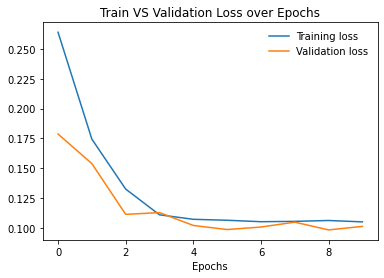

In [38]:
t = [np.mean(tloss[el]) for el in tloss]
v = [np.mean(vloss[el]) for el in vloss]

plt.plot(t, label='Training loss')
plt.plot(v, label='Validation loss')
plt.title("Train VS Validation Loss over Epochs")
plt.xlabel("Epochs")
plt.legend(frameon=False)

# Test 

In [39]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9914 entries, 0 to 9913
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Hour               9914 non-null   category
 1   AMorPM             9914 non-null   category
 2   Weekday            9914 non-null   category
 3   pickup_latitude    9914 non-null   float64 
 4   pickup_longitude   9914 non-null   float64 
 5   dropoff_latitude   9914 non-null   float64 
 6   dropoff_longitude  9914 non-null   float64 
 7   passenger_count    9914 non-null   float64 
 8   dist_km            9914 non-null   float64 
dtypes: category(3), float64(6)
memory usage: 572.5 KB


In [40]:
df_test_cats = df_test[['Hour', 'AMorPM', 'Weekday']]
test_cats = df_test_cats.astype(np.int64)
test_cats = torch.tensor(test_cats.values).cuda()

df_test_conts = df_test[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']]
test_conts = df_test_conts.astype(np.float32)
test_conts = torch.tensor(test_conts.values).cuda()

In [41]:
with torch.no_grad():
    model.eval()
    output = model.forward(test_cats,test_conts).cuda()

In [42]:
output

tensor([2.1867, 2.2205, 1.6777,  ..., 3.5593, 2.9318, 1.7294], device='cuda:0')

In [43]:
len(output)

9914

In [44]:
type(output)

torch.Tensor

In [45]:
np_output = output.cpu().numpy()

In [46]:
type(np_output)

numpy.ndarray

In [47]:
np_output

array([2.1866698, 2.2205129, 1.6776825, ..., 3.5593061, 2.9317951,
       1.7293743], dtype=float32)

In [48]:
np_output_exp = np.exp(np_output)

In [49]:
np_output_exp

array([ 8.905507 ,  9.212054 ,  5.3531356, ..., 35.13881  , 18.76128  ,
        5.6371255], dtype=float32)

In [50]:
df_output =  pd.DataFrame(np_output_exp)

In [51]:
df_output

,0
0,8.905507
1,9.212054
2,5.353136
3,7.410548
4,14.470288
...,...
9909,7.650444
9910,11.516541
9911,35.138809
9912,18.761280
